# Final Project Submission

Please fill out:
* Student name: Peder Norr
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

A smart understanding of which water pumps will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.
This proposal contains an analysis of Tanzanian water pump data in order to provide the Tanzania Ministry of Water a tool with which to determine water pump functionality and information on how to improve pump maintenance efficiency. Initial analysis of water pump data shows that the location of a pump, the age of a pump, the size of population surrounding the pump, and the quantity of water a pump has access to are the biggest indicators of a pumps's functionality status. The Tanzanian Ministry of Water can use this analysis to improve prediction and identification of which pumps are non functional or may need repair, therefore increasing access to potable water across Tanzania.

## Business Problem

The Tanzania Ministry of Water is trying to improve their water pump maintenance operations in order to ensure that clean, potable water is available to communities across Tanzania. In order to accomplish this, the Ministry wants to be able to better predict which pumps will fail, and to better identify pumps that need repair now. This is in hopes of improving maintenance efficiency and water access. Using water pump data, I create a model that can help identify pumps needing repair and characteristics that may indicate pump failure in the future.


# OBTAIN

## Data Understanding

The data used in this analysis come from the Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water, by way of the [DrivenData Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/) competition. The data set contains  41 variables describing pump functionality status (the target variable), pump geographic location, what kind of pump is operating, when it was installed, how it is managed, etc. It includes data on 59,400 individual pumps recorded from 2011-2013.

Import necessary packages

In [35]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import missingno as missingno

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from xgboost import XGBRFClassifier

from imblearn.over_sampling import SMOTE,SMOTENC

!pip install yellowbrick
from yellowbrick.classifier import ROCAUC

!pip install lime
from lime.lime_tabular import LimeTabularExplainer

Set pandas and seaborn options

In [36]:
pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.8f' % x)

Import data

In [37]:
training_values_df= pd.read_csv('data/training-set-values.csv')
training_values_df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.00000000,2013-02-25,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.00000000,2013-01-28,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.00000000,2011-07-13,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.00000000,2013-05-03,Germany Republi,1210,CES,37.16980689,-3.25384746,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.00000000,2011-05-07,Cefa-njombe,1212,Cefa,35.24999126,-9.07062880,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.00000000,2011-04-11,NaN,0,NaN,34.01708706,-8.75043433,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.00000000,2011-03-08,Malec,0,Musa,35.86131531,-6.37857327,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [38]:
training_labels_df = pd.read_csv('data/training-set-labels.csv')
training_labels_df

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


Combine dataframes to create complete dataframe

In [39]:
raw_training_df = pd.merge(training_labels_df, training_values_df)
raw_training_df

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.00000000,2013-02-25,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.00000000,2013-01-28,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.00000000,2011-07-13,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.00000000,2013-05-03,Germany Republi,1210,CES,37.16980689,-3.25384746,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,functional,4700.00000000,2011-05-07,Cefa-njombe,1212,Cefa,35.24999126,-9.07062880,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,functional,0.00000000,2011-04-11,NaN,0,NaN,34.01708706,-8.75043433,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,functional,0.00000000,2011-03-08,Malec,0,Musa,35.86131531,-6.37857327,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [40]:
training_df = raw_training_df.copy()
training_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.00000000,2013-02-25,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.00000000,2013-01-28,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.00000000,2011-07-13,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [41]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

# SCRUB

Check data for duplicates

In [42]:
duplicates = training_df.duplicated(keep = False)
duplicates.value_counts()

False    59400
dtype: int64

No duplicates

Check for null values

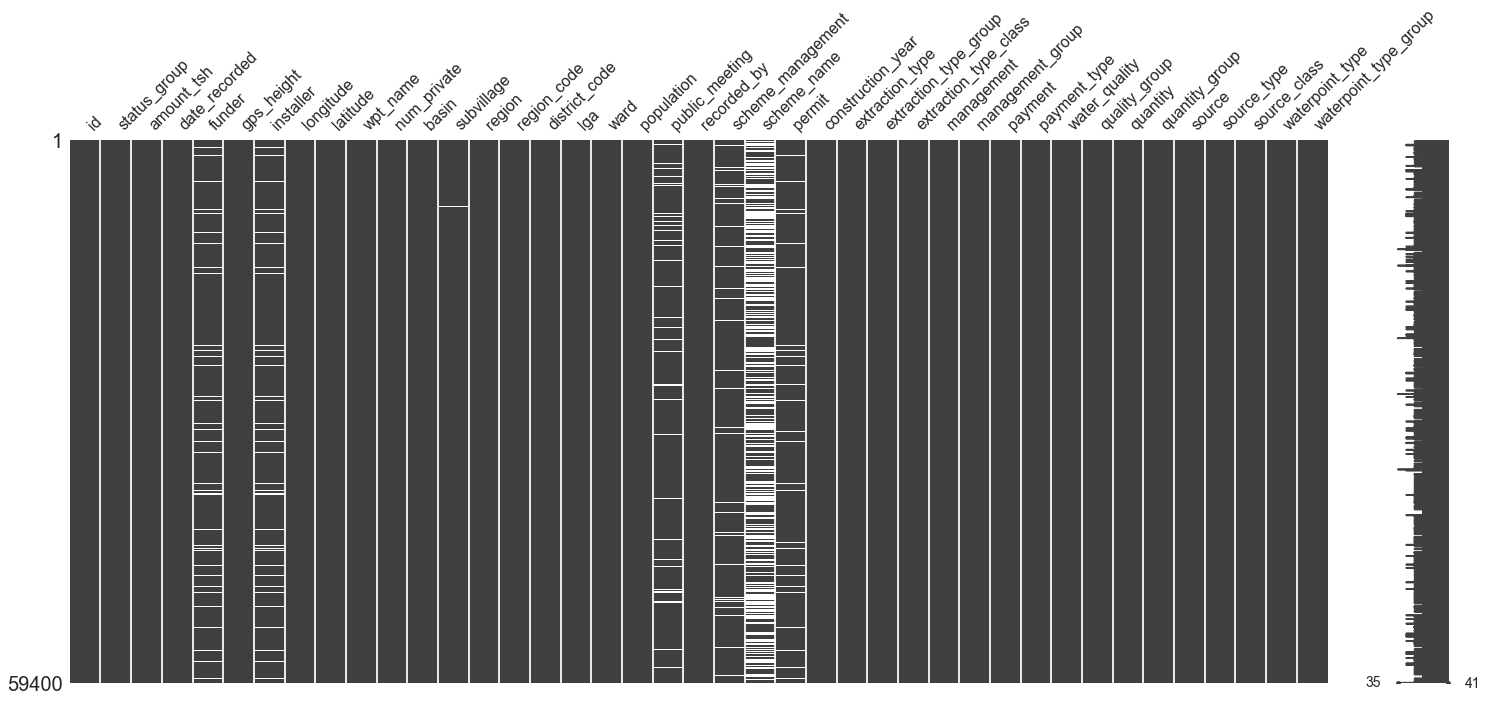

,#null,%null
id,0,0.00000000
status_group,0,0.00000000
amount_tsh,0,0.00000000
date_recorded,0,0.00000000
funder,3635,6.12000000
gps_height,0,0.00000000
installer,3655,6.15000000
longitude,0,0.00000000
latitude,0,0.00000000
wpt_name,0,0.00000000


In [43]:
#Original source https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_30_ensemble_methods/topic_30_ensemble_methods-SG.ipynb

missingno.matrix(training_df)
plt.show()
null_check = pd.DataFrame({
    '#null':training_df.isna().sum(),
    '%null':round(training_df.isna().sum()/len(training_df)*100,2)
})
null_check


Check for nulls that may be represented by zeros

In [44]:
for column in training_df:
    print(training_df[column].value_counts(dropna=False).head(30))
    print("Number of unique values: ")
    print(len(training_df[column].value_counts()))
    print()

2047     1
72310    1
49805    1
51852    1
62091    1
64138    1
57993    1
60040    1
33413    1
35460    1
45699    1
41601    1
43648    1
70263    1
68212    1
20442    1
23134    1
19036    1
29275    1
25177    1
27224    1
4695     1
6742     1
597      1
2644     1
10832    1
53839    1
55886    1
55950    1
53903    1
Name: id, dtype: int64
Number of unique values: 
59400

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64
Number of unique values: 
3

0.00000000        41639
500.00000000       3102
50.00000000        2472
1000.00000000      1488
20.00000000        1463
200.00000000       1220
100.00000000        816
10.00000000         806
30.00000000         743
2000.00000000       704
250.00000000        569
300.00000000        557
5000.00000000       450
5.00000000          376
25.00000000         356
3000.00000000       334
1200.00000000       267
1500.00000000       197
6.00000000          1

VWC                 36793
WUG                  5206
NaN                  3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64
Number of unique values: 
12

NaN                                      28166
K                                          682
None                                       644
Borehole                                   546
Chalinze wate                              405
M                                          400
DANIDA                                     379
Government                                 320
Ngana water supplied scheme                270
wanging'ombe water supply s                261
wanging'ombe supply scheme                 234
Bagamoyo wate                              229
I                             

In [45]:
training_df.nunique()

id                       59400
status_group                 3
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_qu

### Train-Test-Split

In [46]:
# Conduct train test split to create training and testing data groups for
# future modeling

y = training_df['status_group'].copy()
X = training_df.drop(columns=['status_group']).copy()

X_train, X_test, y_train,y_test  = train_test_split(X,y,test_size=.3,
                                                    random_state=4,
                                                    stratify=y)
y_train.value_counts(normalize=True)

functional                0.54307359
non functional            0.38424723
functional needs repair   0.07267917
Name: status_group, dtype: float64

In [47]:
X_train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2555
gps_height                   0
installer                 2570
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 269
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2313
recorded_by                  0
scheme_management         2707
scheme_name              19794
permit                    2155
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Remove unnecessary columns:
* `id` I determined to be irrelevant to the model
- `amount_tsh` is ~70% zeros
*`date_recorded` I determined to be irrelevant to the model
*`num_private` is is ~99% zeros and I was unable to find a definition for the feature
*`recorded_by` I determined to be irrelevant to the model
* `payment_type` I determined to be equivalent to `payment` and therefore redundant
* `quantity_group` I determined to be nearly equivalent to `quantity` and therefore redundant
* `waterpoint_type_group` I determined to be nearly eqivalent to `waterpoint_type` and therefore redundant
* `scheme_name` is  ~50% nulls
* `subvillage` This feature has an unrealistic number of values to OneHotEncode and can be captured by other geographic features
* `wpt_name` I determined to be irrelevant to the model and has too many values

In [48]:
columns = ['id','amount_tsh',  'num_private', 'date_recorded', 
          'quantity_group', 'recorded_by','payment_type', 
          'waterpoint_type_group', 'scheme_name', 'subvillage', 'wpt_name']

X_train.drop(columns, axis=1, inplace=True)
X_test.drop(columns, axis=1, inplace=True)
    

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [49]:
display(X_train.head())
X_test.head()

,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
25389,Government Of Tanzania,0,DWE,35.74608634,-6.38085616,Rufiji,Dodoma,1,5,Dodoma Urban,Mpunguzi,0,True,VWC,False,0,mono,mono,motorpump,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,other
53681,Concern World Wide,0,DWE,31.38982125,-2.70377602,Lake Victoria,Kagera,18,4,Biharamulo,Nyarubungo,0,True,VWC,True,0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,improved spring
36183,Government Of Tanzania,256,DWE,36.91014012,-7.83640050,Rufiji,Morogoro,5,3,Kilombero,Mang'ula,150,True,WUA,True,1978,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,river,river/lake,surface,communal standpipe
50163,Undp,0,BESADA,33.67400613,-3.74998506,Internal,Shinyanga,17,8,Kishapu,Ukenyenge,0,False,Parastatal,False,0,gravity,gravity,gravity,parastatal,parastatal,unknown,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe
4794,Hesawa,0,DWE,33.04266426,-2.49822022,Lake Victoria,Mwanza,19,2,Magu,Bujashi,0,True,VWC,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump


,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
31860,Unicef,0,UNICEF,30.63997958,-2.78726126,Lake Victoria,Kagera,18,30,Ngara,Rulenge,0,True,VWC,False,0,india mark iii,india mark iii,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump
50731,Kkkt_makwale,0,KKKT _ Konde and DWE,33.95774304,-9.40296009,Lake Nyasa,Mbeya,12,3,Kyela,Matema,0,True,VWC,True,0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe
37529,Cmcr,0,Commu,35.98917543,-5.88782909,Wami / Ruvu,Dodoma,1,5,Dodoma Urban,Hombolo,0,True,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe
41990,Isf,952,DWE,29.74053072,-4.75518579,Lake Tanganyika,Kigoma,16,3,Kigoma Rural,Mahembe,165,True,VWC,True,2005,gravity,gravity,gravity,wug,user-group,pay monthly,soft,good,enough,river,river/lake,surface,communal standpipe multiple
51897,Dwe/norad,1300,DWE,31.21231465,-8.43149966,Lake Tanganyika,Rukwa,15,2,Sumbawanga Rural,Kasanga,450,True,VWC,True,1986,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,river,river/lake,surface,communal standpipe


Address columns that have nulls represented by zeros

In [50]:
# Replace zeros for median for gps_height and population

columns = ['gps_height', 'population']

for column in columns:
    X_train[column].replace(0, X_train[column].median() , inplace=True)
    X_test[column].replace(0, X_train[column].median() , inplace=True)
    
display(X_train['gps_height'].value_counts())
X_test['gps_height'].value_counts()


C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

 374     14322
-15         43
-13         42
-16         41
 1286       39
         ...  
 2172        1
 2261        1
-90          1
 2120        1
 2186        1
Name: gps_height, Length: 2372, dtype: int64

 374     6136
-18        20
-19        20
 1602      18
 1290      18
         ... 
 2134       1
 2166       1
 2182       1
 2198       1
 2049       1
Name: gps_height, Length: 2214, dtype: int64

In [51]:
display(X_train['population'].value_counts())
X_test['population'].value_counts()

27      15024
1        4816
200      1349
150      1323
250      1166
        ...  
3014        1
1831        1
1863        1
975         1
1439        1
Name: population, Length: 942, dtype: int64

27      6362
1       2209
200      591
150      569
250      515
        ... 
731        1
635        1
619        1
421        1
1375       1
Name: population, Length: 659, dtype: int64

In [52]:
# Replace zeros with median for construction_year

X_train['construction_year'].replace(0, X_train['construction_year'].median(),
                                     inplace=True)
X_test['construction_year'].replace(0, X_test['construction_year'].median(),
                                    inplace=True)

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [53]:
display(X_train['construction_year'].value_counts())
X_test['construction_year'].value_counts()

1986    14856
2008     1835
2010     1809
2009     1751
2000     1506
2007     1151
2006     1029
2003      900
2011      862
2004      802
2002      748
2012      744
2005      707
1995      703
1999      702
1978      695
1990      686
1998      668
1985      662
1996      567
1980      563
1984      545
1982      525
1994      520
1972      510
1974      462
1997      450
1992      449
1993      420
2001      385
1988      363
1983      338
1975      307
1970      284
1976      280
1991      225
1989      214
1987      214
1981      163
1977      138
1979      136
1973      130
2013      119
1971       91
1960       70
1967       63
1963       58
1968       48
1969       42
1964       24
1962       23
1965       15
1961       15
1966        8
Name: construction_year, dtype: int64

1985    6452
2010     836
2009     782
2008     778
2000     585
2006     442
2007     436
2011     394
2003     386
1978     342
2012     340
2002     327
2004     321
1995     311
2005     304
1998     298
1999     277
1990     268
1980     248
1996     244
1984     234
1982     219
1994     218
1974     214
1972     198
1997     194
1992     191
1993     188
1988     158
2001     155
1983     150
1976     134
1975     130
1970     127
1986     118
1989     102
1991      99
1987      88
1981      75
1977      64
2013      57
1979      56
1973      54
1971      54
1960      32
1968      29
1963      27
1967      25
1969      17
1964      16
1966       9
1962       7
1961       6
1965       4
Name: construction_year, dtype: int64

In [54]:
# Replace zeros with mean for longitude

X_train['longitude'].replace(0.000000, X_train['longitude'].mean(),
                             inplace=True)
X_test['longitude'].replace(0.000000, X_test['longitude'].mean(),
                            inplace=True)

In [55]:
display(X_train['longitude'].value_counts())
X_test['longitude'].value_counts()

34.06735422    1269
39.09568416       2
39.09143391       2
39.09087979       2
33.01559667       2
               ... 
39.11849099       1
29.83615555       1
33.82117793       1
36.86274516       1
33.56431034       1
Name: longitude, Length: 40269, dtype: int64

34.10092913    543
32.92601185      2
39.10530661      2
32.95559708      2
32.98269806      2
              ... 
36.91948719      1
36.82065297      1
35.94557539      1
31.50718577      1
33.51402674      1
Name: longitude, Length: 17271, dtype: int64

In [56]:
# Replace zeros with mean for latitude

X_train['latitude'].replace(-0.00000002, X_train['latitude'].mean(),
                            inplace=True)
X_test['latitude'].replace(-0.00000002, X_test['latitude'].mean(),
                           inplace=True)

In [57]:
display(X_train['latitude'].value_counts())
X_test['latitude'].value_counts()

-5.70208747    1269
-2.49194214       2
-2.50658954       2
-6.99261144       2
-7.10492257       2
               ... 
-4.65590524       1
-3.27739385       1
-3.82601364       1
-4.09186786       1
-3.02488162       1
Name: latitude, Length: 40269, dtype: int64

-5.71523811    543
-6.97559391      2
-2.50162744      2
-2.51661892      2
-6.97596494      2
              ... 
-7.08444543      1
-2.16454296      1
-4.59435642      1
-2.83602734      1
-5.60075821      1
Name: latitude, Length: 17271, dtype: int64

In [58]:
#Checking dtypes
X_train.dtypes

funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
scheme_management         object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

Convert `permit` and `public_meeting` to `int` to cooperate with the encoder

In [59]:
# Fill nulls with False for permit and public_meeting

bool_columns = ['permit', 'public_meeting']

for column in bool_columns:
    X_train[column].fillna(False, inplace = True)
    X_test[column].fillna(False, inplace = True)

display(X_train['permit'].value_counts(dropna=False))
X_test['permit'].value_counts(dropna=False)

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


True     27080
False    14500
Name: permit, dtype: int64

True     11772
False     6048
Name: permit, dtype: int64

In [60]:
display(X_train['public_meeting'].value_counts(dropna=False))
X_test['public_meeting'].value_counts(dropna=False)

True     35768
False     5812
Name: public_meeting, dtype: int64

True     15243
False     2577
Name: public_meeting, dtype: int64

In [61]:
X_train['permit'] = X_train['permit'].astype('int')
X_train['public_meeting'] = X_train['public_meeting'].astype('int')
X_test['permit'] = X_test['permit'].astype('int')
X_test['public_meeting'] = X_test['public_meeting'].astype('int')
display(X_train.dtypes)
X_test.dtypes

<ipython-input-61-4002bb6dc098>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['permit'] = X_train['permit'].astype('int')
<ipython-input-61-4002bb6dc098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['public_meeting'] = X_train['public_meeting'].astype('int')
<ipython-input-61-4002bb6dc098>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

In [62]:
X_train['permit'].value_counts()

1    27080
0    14500
Name: permit, dtype: int64

Convert `region_code` and `district_code` to categorical features

In [63]:
X_train['region_code'] = X_train['region_code'].astype('str')
X_train['district_code'] = X_train['district_code'].astype('str')
X_test['region_code'] = X_test['region_code'].astype('str')
X_test['district_code'] = X_test['district_code'].astype('str')
display(X_train.dtypes)
X_test.dtypes

<ipython-input-63-86337711cda7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['region_code'] = X_train['region_code'].astype('str')
<ipython-input-63-86337711cda7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['district_code'] = X_train['district_code'].astype('str')
<ipython-input-63-86337711cda7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code               object
district_code             object
lga                       object
ward                      object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code               object
district_code             object
lga                       object
ward                      object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

Convert `funder` to `str`

In [64]:
X_train['funder'] = X_train['funder'].astype('str')
X_test['funder'] = X_test['funder'].astype('str')

<ipython-input-64-27508446b04b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['funder'] = X_train['funder'].astype('str')
<ipython-input-64-27508446b04b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['funder'] = X_test['funder'].astype('str')


Create list of numerical and categorical columns

In [65]:
numerical_cols = list(X_train.select_dtypes('number').columns)
categorical_cols = list(X_train.select_dtypes('object').columns)
numerical_cols,categorical_cols

(['gps_height',
  'longitude',
  'latitude',
  'population',
  'public_meeting',
  'permit',
  'construction_year'],
 ['funder',
  'installer',
  'basin',
  'region',
  'region_code',
  'district_code',
  'lga',
  'ward',
  'scheme_management',
  'extraction_type',
  'extraction_type_group',
  'extraction_type_class',
  'management',
  'management_group',
  'payment',
  'water_quality',
  'quality_group',
  'quantity',
  'source',
  'source_type',
  'source_class',
  'waterpoint_type'])

In [66]:
X_train[categorical_cols].nunique()

funder                   1587
installer                1788
basin                       9
region                     21
region_code                27
district_code              20
lga                       125
ward                     2080
scheme_management          12
extraction_type            18
extraction_type_group      13
extraction_type_class       7
management                 12
management_group            5
payment                     7
water_quality               8
quality_group               6
quantity                    5
source                     10
source_type                 7
source_class                3
waterpoint_type             7
dtype: int64

Create pipelines and column transformer

In [67]:
numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='MISSING')),
    ('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

Combine pipelines into one with column transformer

In [68]:
preprocessor=ColumnTransformer(transformers=[
    ('num',numerical_transformer,numerical_cols),
    ('cat',categorical_transformer,categorical_cols)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['gps_height', 'longitude', 'latitude',
                                  'population', 'public_meeting', 'permit',
                                  'construction_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['funder', 'installer', 'basin', 'region',
                        

Fit and use preprocessor to process X_train and X_test (fill in nulls and one hot encode categorical variables)

In [69]:
# Fit preprocessing pipeline on training data 
# and pull out the feature names and X_cols

preprocessor.fit(X_train)

# Use the encoder's .get_feature_names
categorical_features = list(preprocessor.named_transformers_['cat']
                            .named_steps['encoder']\
                            .get_feature_names(categorical_cols))
X_cols = numerical_cols+categorical_features

# Transform X_train, X_test and remake dataframes
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index, columns=X_cols)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          index=X_test.index, columns=X_cols)

# Tranform X_train and X_test and make into dataFrames
X_train_df.head()

,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,funder_0,funder_A/co Germany,funder_Aar,funder_Abasia,funder_Abc-ihushi Development Cent,funder_Abd,funder_Abddwe,funder_Abdul,funder_Abood,funder_Aco/germany,funder_Acord,funder_Acord Ngo,funder_Acra,funder_Act,funder_Action Aid,funder_Action Contre La Faim,funder_Action In A,funder_Adap,funder_Adb,funder_Adf,funder_Adp,funder_Adp Bungu,funder_Adp Mombo,funder_Adp/w,funder_Adra,funder_Af,funder_Afdp,funder_Afric,funder_Africa,funder_Africa 2000 Network/undp,funder_Africa Amini Alama,funder_African,funder_African 2000 Network,...,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
25389,374.00000000,35.74608634,-6.38085616,27.00000000,1.00000000,0.00000000,1986.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
53681,374.00000000,31.38982125,-2.70377602,27.00000000,1.00000000,1.00000000,1986.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
36183,256.00000000,36.91014012,-7.83640050,150.00000000,1.00000000,1.00000000,1978.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000

# EXPLORE

Check for class imbalance

<AxesSubplot:xlabel='status_group', ylabel='count'>

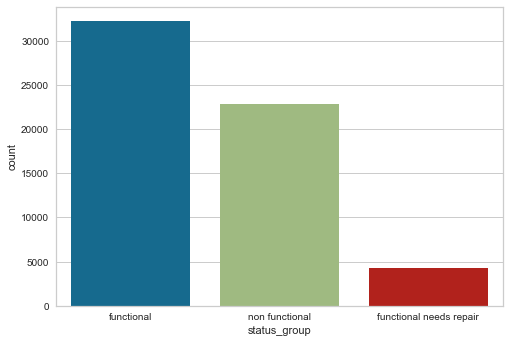

In [70]:
sns.countplot(x='status_group', data=training_df)

Show distribution of pumps across Tanzania

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

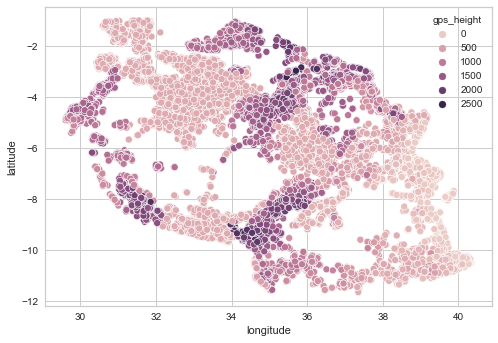

In [71]:
sns.scatterplot(x=X_train_df['longitude'], y=X_train_df['latitude'],
            hue=X_train_df['gps_height'])

# MODEL

### Model Evaluation Function

### Baseline Model (Dummy Classifier)

Create a baseline dummy classifier model as a starting point

In [72]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_df,y_train)
y_pred_test = dummy_clf.predict(X_test_df)
print(metrics.classification_report(y_test, y_pred_test))

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


                         precision    recall  f1-score   support

             functional       0.54      0.54      0.54      9678
functional needs repair       0.07      0.07      0.07      1295
         non functional       0.38      0.38      0.38      6847

               accuracy                           0.45     17820
              macro avg       0.33      0.33      0.33     17820
           weighted avg       0.44      0.45      0.45     17820



With an accuracy of 0.45 and f1 scores ranging from 0.08 to 0.55, the dummy classifier does no better than if one were to just guess the functional status group of the pump.

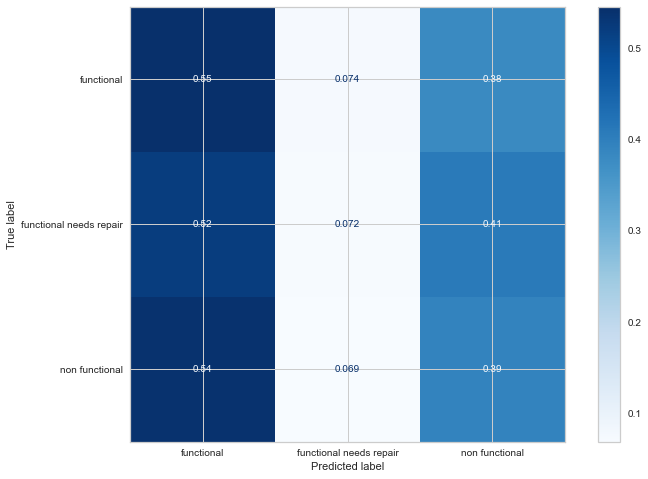

In [74]:
fig,ax = plt.subplots(ncols=1, figsize=(12,8))
metrics.plot_confusion_matrix(dummy_clf, X_test_df,y_test, normalize='true',
                              ax=ax, cmap='Blues')
ax.grid('off')

The confusion matrix above shows the discrepancy between the dummy classifier's predicted status group label for a given pump vs the true status group label. The dummy classifier does no better than guessing at random.

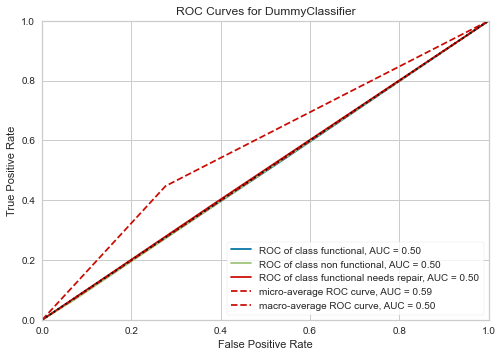

<AxesSubplot:title={'center':'ROC Curves for DummyClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [39]:
visualizer = ROCAUC(dummy_clf, classes=['functional', 'non functional',
                                        'functional needs repair'])
visualizer.fit(X_train_df, y_train)
visualizer.score(X_test_df, y_test)
visualizer.show()


The ROCAUC figure above shows an AOC figure of 0.50, deeming the dummy classifier useless.

In [40]:
print(f"Training Score = {dummy_clf.score(X_train_df,y_train):.2f}")
print(f"Test Score = {dummy_clf.score(X_test_df,y_test):.2f}")

Training Score = 0.45
Test Score = 0.45


The mean accuracy scores (0.45 for the training data and 0.45 for the test data) above show that while the dummy classifier is not over fit, it has a very poor mean accuracy.

### RandomForestClassifier 1

Create a Random Forest Classifier

In [41]:
rf_1 = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                              random_state=4)
rf_1.fit(X_train_df, y_train)
y_pred_test = rf_1.predict(X_test_df)
print(metrics.classification_report(y_test, y_pred_test))

                         precision    recall  f1-score   support

             functional       0.81      0.86      0.83      9678
functional needs repair       0.51      0.35      0.42      1295
         non functional       0.81      0.78      0.80      6847

               accuracy                           0.79     17820
              macro avg       0.71      0.67      0.68     17820
           weighted avg       0.79      0.79      0.79     17820



With an accuracy of 0.79 and f1 scores of 0.42, 0.80, and 0.83, the initial Random Forest does a far better job of predicting the status group of a given pump.

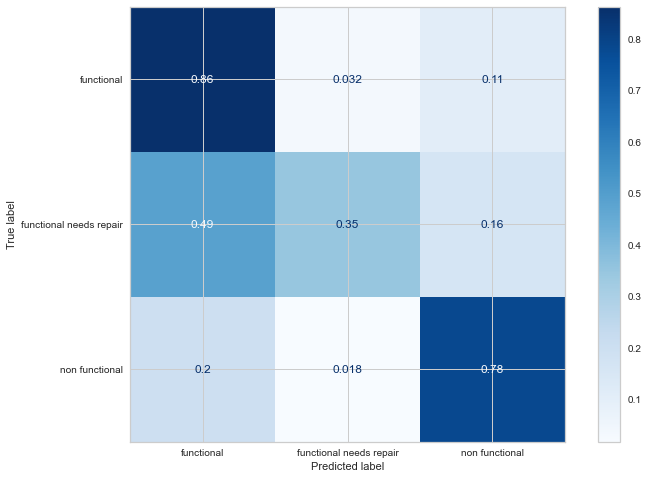

In [42]:
fig,ax = plt.subplots(ncols=1, figsize=(12,8))
metrics.plot_confusion_matrix(rf_1, X_test_df,y_test, normalize='true', ax=ax,
                              cmap='Blues')

The confusion matrix above shows the discrepancy between the Random Forest's predicted status group label for a given pump vs the true status group label. The model does an excellent job predicting the `functional` and `non functional` statuses correctly (precision of 0.81 for each, and recall of 0.86, and 0.78 respectively). However, it struggles to accurately predict the `functional needs repair` status (precision of 0.51 and recall of 0.35).

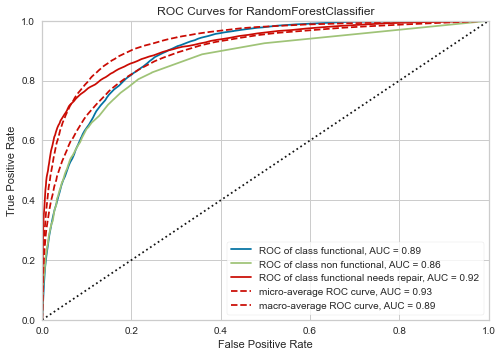

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [43]:
visualizer = ROCAUC(rf_1, classes=['functional', 'non functional',
                                   'functional needs repair'])
visualizer.fit(X_train_df, y_train)
visualizer.score(X_test_df, y_test)
visualizer.show()

The ROCAUC figure above shows an AOC figure of 0.89 for `functional`, 0.86 for `non functional`, and 0.92 for `functional needs repair`,  deeming the initial Random Forest model quite impressive.

In [44]:
print(f"Training Score = {rf_1.score(X_train_df,y_train):.2f}")
print(f"Test Score = {rf_1.score(X_test_df,y_test):.2f}")

Training Score = 1.00
Test Score = 0.79


The mean accuracy scores (1.00 for the training data and 0.79 for the test data) above show that the Random Forest is somewhat overfit. However, it does have an impressive mean accuracy score for the test data.

<AxesSubplot:title={'center':'Feature Importances'}, ylabel='Feature'>

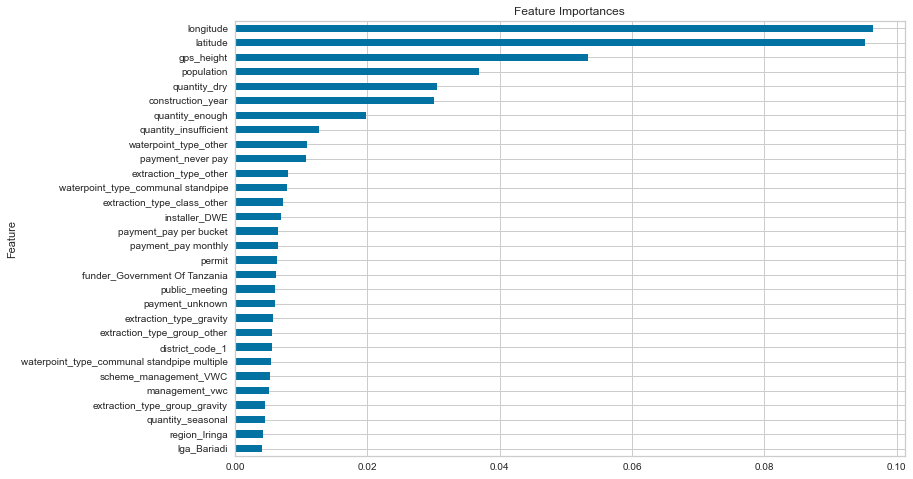

In [45]:
feature_importance_df = pd.Series(rf_1.feature_importances_,
                              index=X_train_df.columns)
feature_importance_df.sort_values(ascending=True).tail(30).plot(
        kind='barh',figsize=(12,8),title='Feature Importances',
        ylabel='Feature')

The above figure shows how important each respective feature is to the model in predicting the status group for a given pump. `Longitude`, `latitude`, `gps height`, `population`, `quantity`, and `construction year` were deemed the most important.

### RandomForestClassifier 1: Hyperparameter Tuning

In this section we use GridSearchCV to tune the hyperparameters of the Random Forest in hopes of increasing accuracy, precision, and recall scores.

In [46]:
X_train_df.shape

(41580, 5786)

In [44]:
#Create parameters grid for use in the GridSearch

param_grid = {'criterion':['gini','entropy'],
              'min_samples_split':[4,6,8],
             'n_estimators':[500, 750, 1000]}

#Create GridSearchCV instance, prioritizing f1 score
#and cross validating 3 times

grid_rf_1 = GridSearchCV(rf_1, param_grid=param_grid, scoring='f1_macro',
                         cv=3, n_jobs=-1, verbose=True)

grid_rf_1.fit(X_train_df, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=4),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [500, 750, 1000]},
             scoring='f1_macro')

In [47]:
print('Best Score: ')
print(grid_rf_1.best_score_)
print('Best Parameters: ')
print(grid_rf_1.best_params_)

Best Score: 
0.6888699787017011
Best Parameters: 
{'criterion': 'gini', 'min_samples_split': 4, 'n_estimators': 1000}


### RandomForestClassifier 2:

Create new Random Forest utilizing best parameters from the GridSearch

In [47]:
rf_2 = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                              random_state=4, **grid_rf_1.best_params_)
rf_2.fit(X_train_df, y_train)
y_pred_test = rf_2.predict(X_test_df)
print(metrics.classification_report(y_test, y_pred_test))

                         precision    recall  f1-score   support

             functional       0.82      0.85      0.83      9678
functional needs repair       0.46      0.44      0.45      1295
         non functional       0.82      0.79      0.80      6847

               accuracy                           0.79     17820
              macro avg       0.70      0.69      0.70     17820
           weighted avg       0.79      0.79      0.79     17820



With an accuracy of 0.79 and f1 scores of 0.45, 0.80, and 0.83, the second iteration of the Random Forest has improved the f1 score of `functional needs repair`.

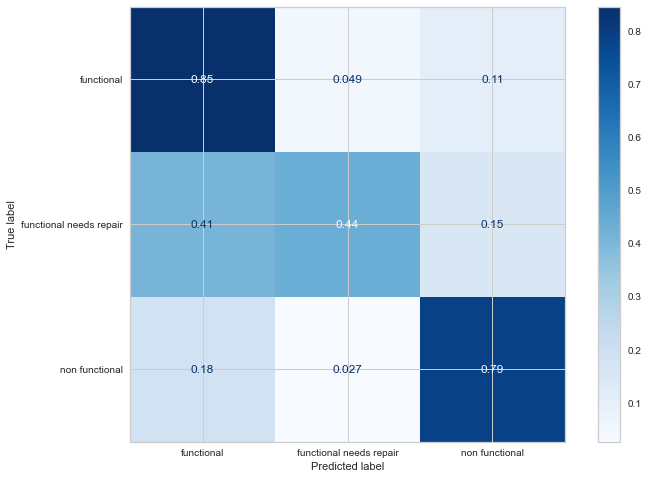

In [48]:
fig,ax = plt.subplots(ncols=1, figsize=(12,8))
metrics.plot_confusion_matrix(rf_2, X_test_df,y_test, normalize='true', ax=ax,
                              cmap='Blues')

The confusion matrix above shows the discrepancy between the Random Forest's predicted status group label for a given pump vs the true status group label. The second iteration of the model does a better job predicting the functional and non functional statuses correctly (precision of 0.82 for each, and recall of 0.85, and 0.79 respectively). However, it still struggles to accurately predict the functional needs repair status (precision of 0.46 and recall of 0.44), although it has improved recall to 0.44.

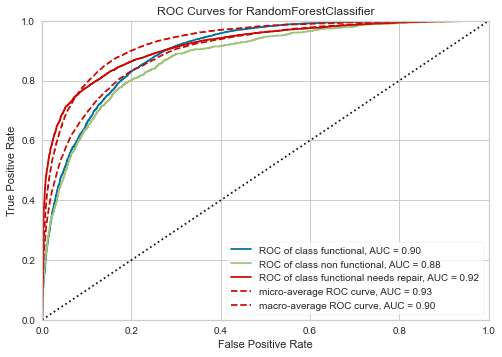

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [49]:
visualizer = ROCAUC(rf_2, classes=['functional', 'non functional',
                                   'functional needs repair'])
visualizer.fit(X_train_df, y_train)
visualizer.score(X_test_df, y_test)
visualizer.show()

The ROCAUC figure above shows an AOC figure of 0.90 for functional, 0.88 for non functional, and 0.92 for functional needs repair, deeming the second iteration Random Forest model quite impressive and improved over the initial.

In [85]:
print(f"Training Score = {rf_2.score(X_train_df,y_train):.2f}")
print(f"Test Score = {rf_2.score(X_test_df,y_test):.2f}")

Training Score = 0.97
Test Score = 0.79


The mean accuracy scores (0.97 for the training data and 0.79 for the test data) above show that the Random Forest is still overfit. However, it has reduced the level of over fitting, and retains an impressive mean accuracy.

<AxesSubplot:title={'center':'Feature Importances'}, ylabel='Feature'>

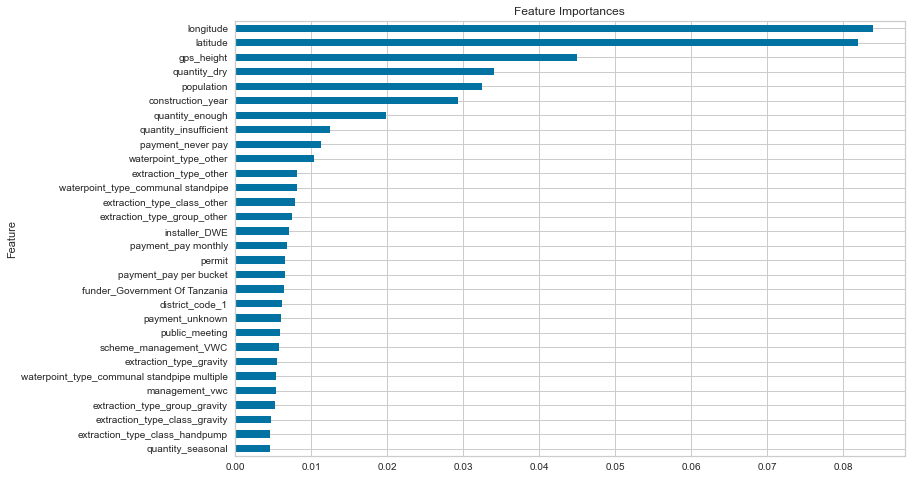

In [50]:
feature_importance_df = pd.Series(rf_2.feature_importances_,
                              index=X_train_df.columns)
feature_importance_df.sort_values(ascending=True).tail(30).plot(
        kind='barh',figsize=(12,8),title='Feature Importances',
        ylabel='Feature')

The above figure shows how important each respective feature is to the model in predicting the status group for a given pump. `Longitude`, `latitude`, `gps height`, `population`, `quantity`, and `construction year` were deemed the most important again.

### RandomForestClassifier 3:

Create third iteration of the Random Forest, further adjusting the parameters by increasing `n_estimators` to 3000

In [51]:
rf_3 = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                              random_state=4, n_estimators=3000,
                              min_samples_split=4)
rf_3.fit(X_train_df, y_train)
y_pred_test = rf_3.predict(X_test_df)
print(metrics.classification_report(y_test, y_pred_test))

                         precision    recall  f1-score   support

             functional       0.82      0.85      0.83      9678
functional needs repair       0.47      0.44      0.45      1295
         non functional       0.82      0.79      0.80      6847

               accuracy                           0.80     17820
              macro avg       0.70      0.69      0.70     17820
           weighted avg       0.79      0.80      0.79     17820



With an accuracy of 0.80 and f1 scores of 0.45, 0.80, and 0.83, the third iteration of the Random Forest has improved the accuracy of the model.

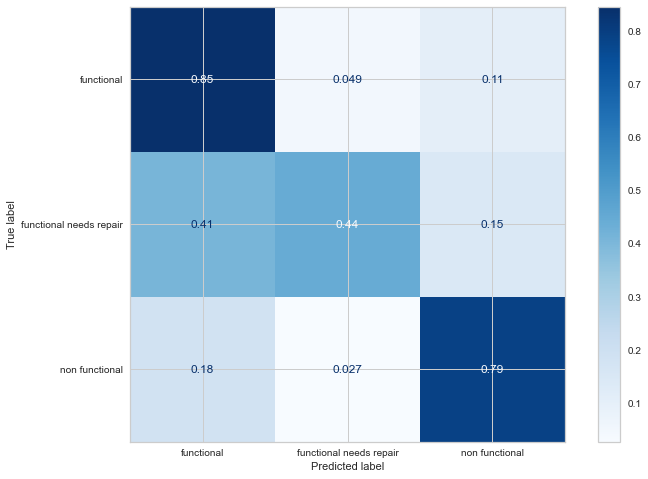

In [52]:
fig,ax = plt.subplots(ncols=1, figsize=(12,8))
metrics.plot_confusion_matrix(rf_3, X_test_df,y_test, normalize='true', ax=ax,
                              cmap='Blues')

The confusion matrix above shows the discrepancy between the Random Forest's predicted status group label for a given pump vs the true status group label. The second iteration of the model does a better job predicting the functional and non functional statuses correctly (precision of 0.82 for each, and recall of 0.85, and 0.79 respectively). However, it still struggles to accurately predict the functional needs repair status (precision of 0.47 and recall of 0.44), although it has improved precision to 0.47.

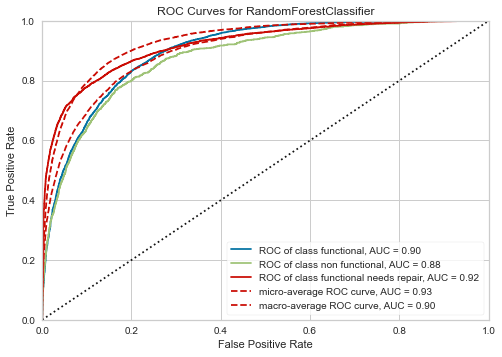

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [53]:
visualizer = ROCAUC(rf_3, classes=['functional', 'non functional',
                                   'functional needs repair'])
visualizer.fit(X_train_df, y_train)
visualizer.score(X_test_df, y_test)
visualizer.show()

The ROCAUC figure above shows an AOC figure of 0.90 for functional, 0.88 for non functional, and 0.92 for functional needs repair, deeming the third iteration Random Forest model quite impressive and improved over the initial.

In [54]:
print(f"Training Score = {rf_3.score(X_train_df,y_train):.2f}")
print(f"Test Score = {rf_3.score(X_test_df,y_test):.2f}")

Training Score = 0.97
Test Score = 0.80


The mean accuracy scores (0.97 for the training data and 0.80 for the test data) above show that the Random Forest is still overfit. However, it has reduced the level of over fitting by improving the test mean accuracy.

<AxesSubplot:title={'center':'Feature Importances'}, ylabel='Feature'>

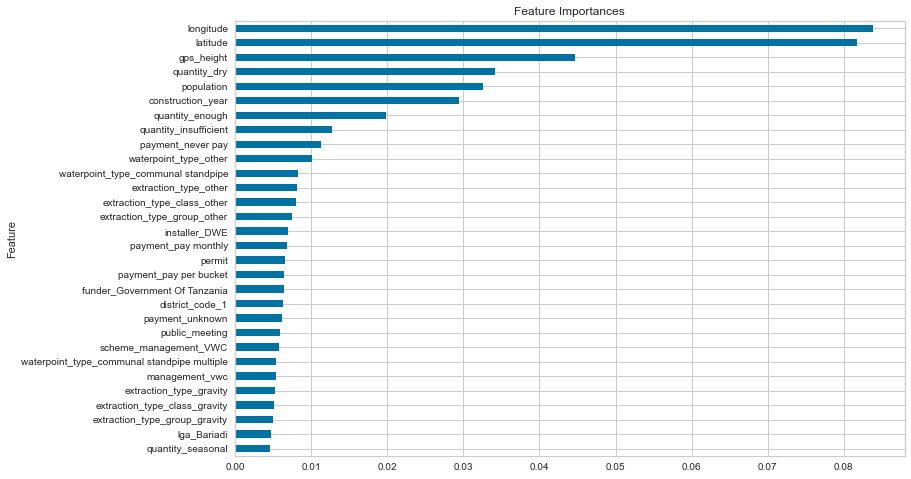

In [55]:
feature_importance_df = pd.Series(rf_3.feature_importances_,
                              index=X_train_df.columns)
feature_importance_df.sort_values(ascending=True).tail(30).plot(
        kind='barh',figsize=(12,8),title='Feature Importances',
        ylabel='Feature')

The above figure shows how important each respective feature is to the model in predicting the status group for a given pump. `Longitude`, `latitude`, `gps height`, `population`, `quantity`, and `construction year` were deemed the most important again.

# iNTERPRET

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

Use LIME to interpret feature importances

In [56]:
#Create LIME instance

lime_explainer =LimeTabularExplainer(
    training_data=np.array(X_test_df),
    feature_names=X_train_df.columns,
    categorical_features= categorical_features, 
    class_names=['functional', 'non functional', 'functional needs repair'],
    mode='classification'
)

In [57]:
#Create random row choice generator

row = np.random.choice(range(len(X_test_df)))

In [58]:
#Create explainer instance for the test data and generate figure

exp = lime_explainer.explain_instance(X_test_df.iloc[row], rf_3.predict_proba,
                                      num_features=10, top_labels=3)
exp.show_in_notebook(show_table=True)

The LIME figure above confirms `quantity` as one of the most important features in determining status group.

In [86]:
#Recreate dataframe for creating visuals
interpret_training_df = training_df.copy()
interpret_training_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.00000000,2013-02-25,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.00000000,2013-01-28,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.00000000,2011-07-13,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [93]:
#Address null values for features to be visualized

interpret_training_df['construction_year'].replace(0,
                                                   interpret_training_df['construction_year'].median(),
                                                   inplace=True)
interpret_training_df['longitude'].replace(0.000000, 
                                           interpret_training_df['longitude'].mean(),
                                           inplace=True)
interpret_training_df['latitude'].replace(-0.00000002,
                                          interpret_training_df['latitude'].mean(),
                                          inplace=True)
interpret_training_df['gps_height'].replace(0,
                                            interpret_training_df['gps_height'].median(),
                                            inplace=True)
interpret_training_df['population'].replace(0, 
                                            interpret_training_df['population'].median(),
                                            inplace=True)

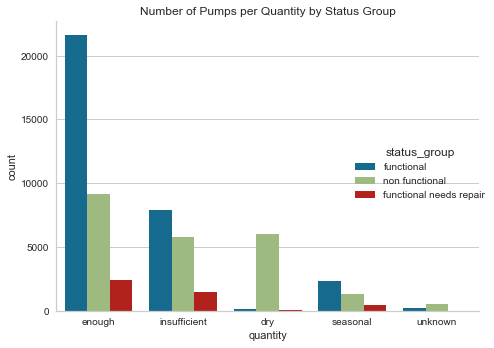

In [97]:
#Create visual interpreting quantity feature

sns.catplot(data=training_df, kind='count', x='quantity', hue='status_group')
plt.title('Number of Pumps per Quantity by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_quantity.png', dpi=150)

The figure above shows how as water quantity decreases, pumps are more likely to be non functional

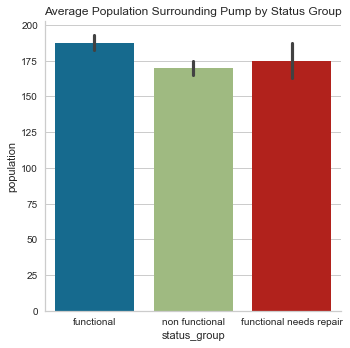

In [98]:
#Create visual to interpret population

sns.catplot(data=training_df, kind='bar', y='population', x='status_group')
plt.title('Average Population Surrounding Pump by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_population.png', dpi=150)

The figure above shows how pumps in areas of lower population may be more likely to be needing repair or non functional

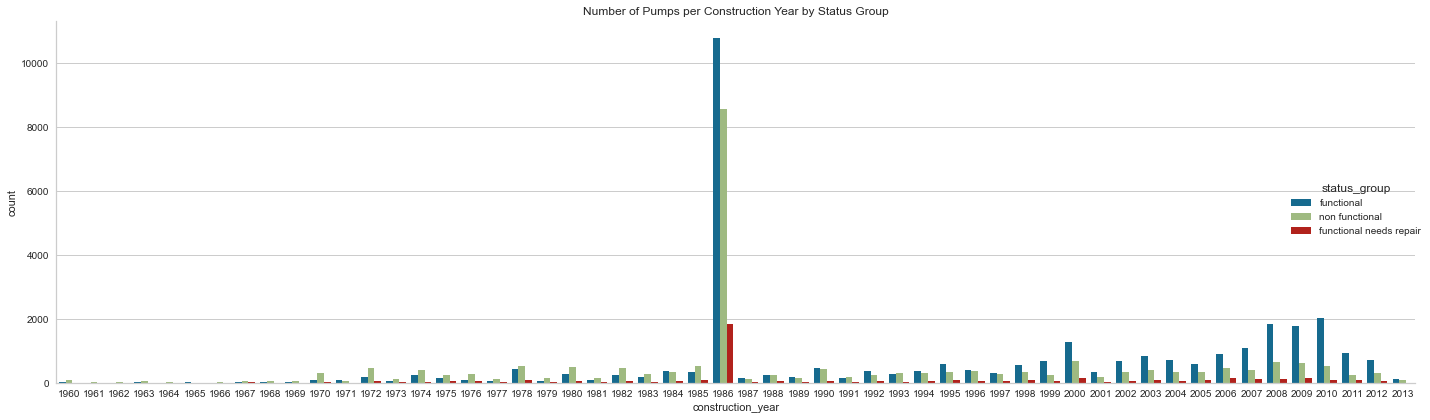

In [99]:
#Create visual to interpret construction year

sns.catplot(data=interpret_training_df, kind='count', x='construction_year',
            hue='status_group', orient='h', aspect=3, height=6)
plt.title('Number of Pumps per Construction Year by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_construction_year.png', dpi=150)

The figure above shows how older pumps are more likely to be nonfunctional or needing repair

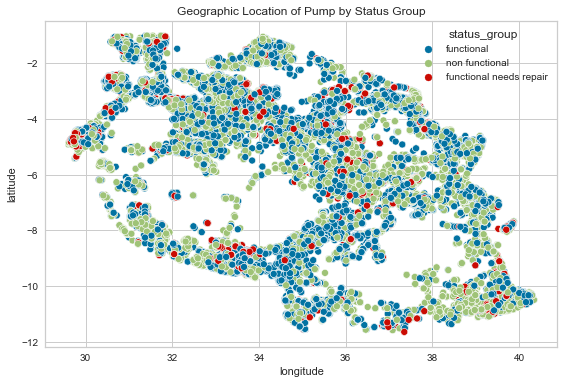

In [100]:
#Create visual to interpret location

sns.scatterplot(data=interpret_training_df, x='longitude', y='latitude',
                hue='status_group')
plt.title('Geographic Location of Pump by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_location_by_groups.png', dpi=150)

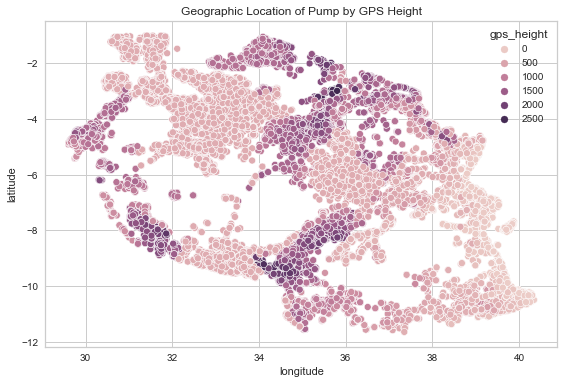

In [101]:
#Create visual to interpret location

sns.scatterplot(x=interpret_training_df['longitude'],
                y=interpret_training_df['latitude'],
                hue=interpret_training_df['gps_height'])
plt.title('Geographic Location of Pump by GPS Height')
plt.tight_layout()

plt.savefig('images/pumps_by_location_by_height.png', dpi=150)

The figures above show that pumps in lower altitude areas may be more likely to be non functional

# CONCLUSIONS & RECOMMENDATIONS

Based on this random forest classifier model, I would provide four recommendations to the Tanzanian Ministry of Water as they look to improve pump status prediction and maintenance efficiency:

- **Location** `Longitude`, `latitude`, and `gps height` were some of the most important features in the random forest classifier. Based on the analysis, pumps in lower altitude areas may be more likely to need repair or be non functional. The Ministry should focus resources on lower altitude pumps.

- **Quantity** `Quantity` was one of the most important features in the random forest classifier. Analysis showed that pumps with lower quantities of water were more likely to be non functional or needing repair. The Ministry should focus resources on pumps with low quantities of water.

- **Population** `Population` was one of the most important features in the random forest classifier. Analysis showed that pumps in lower population areas may be more likely to be non functional or needing repairs. The Ministry of Water should focus resources on low population areas, as they may not be receiving enough.

- **Construction Year** `Construction Year` was one of the most important features in the random forest classifier. Analysis showed that older pumps may be more likely to be nonfunctional or needing repair. The Ministry should focus resources on modernizing older pumps.

However, the random forest model and analysis are not complete solutions, nor are they perfect. The final model still struggles with correctly identifying pumps classified as `functional needs repair`, too often mistaking them for `functional` pumps. But as `functional needs repair` pumps make up a very small part of the data set, I believe this to be a tolerable risk and that the model is accurate to a degree that makes it useful for the Ministry of Water as a tool to improve pump status prediction and maintenance efficiency.

I could improve this analysis in the future by further transforming and scrubbing the data to create more helpful features and cleaner data, further tweaking the hyperparameters of the model, or by utilizing a XGBoost, LightGBM, or CatBoost model. However, due to the size of the data set, and my own computing limitations, I was unable to leverage those models at the time.